In [1]:
# Import Libraries and Dependencies
import constrained_optimization
from constrained_optimization.base import*
from constrained_optimization.generate import*

In [4]:
dimX = 1000
dimY = 100
dimU = 100

import time
start_time = time.time()
p, q, r, A, b = randQCQP(dimX,dimY,True,True, dimU)
print("--- %s seconds ---" % (time.time() - start_time))


--- 3.4357004165649414 seconds ---


In [5]:
p, q, r, A, b = randQCQPmat(dimX,dimY,True,True, dimU)

--- 77.44616961479187 seconds ---


In [3]:
M_ = 3
N_ = 2
convex_ = False

x_rand = np.random.rand(N_)
q_temp = np.random.rand(M_+1, N_)
p_temp = np.random.rand(M_+1, N_, N_)
if convex_:
    p_temp = np.matmul(p_temp, np.transpose(p_temp, (0,2,1)))
else :
    p_temp = np.maximum(p_temp, np.transpose(p_temp, (0,2,1)))
r_temp = -0.5*np.transpose(x_rand)@p_temp@x_rand - q_temp@x_rand

In [11]:

#start_time = time.time()
#fx, hx, gradf, gradh = toQCQPmat(p, q, r)
#print("--- %s seconds ---" % (time.time() - start_time))
hxs = []
gradhs = []
for i in range(len(hx)):
    temp = lambda x: -1*hx[i](x)
    hxs.append(temp)
    temp = lambda x: -1*gradh[i](x)
    gradhs.append(temp)

In [12]:
fx, hx, gradf, gradh = toQCQP(p, q, r)

In [27]:
prob = co_problem(fx, dimX, hx, None, gradf, gradh, A, b)

x = np.ones(30)
F_co, J_co = prob.get_parameters(False)
F_co(x)

array([ 3.01043010e+03,  3.02007000e+03,  3.02072481e+03,  3.01799809e+03,
        3.01944641e+03,  3.01569789e+03,  3.00665322e+03,  3.02325034e+03,
        3.01204337e+03,  3.00659912e+03, -1.02573524e+02, -1.02573524e+02,
       -1.02573524e+02, -1.02573524e+02, -1.02573524e+02, -1.02573524e+02,
       -1.02573524e+02, -1.02573524e+02, -1.02573524e+02, -1.02573524e+02,
       -2.74222587e+00, -1.90471110e+00, -2.09242528e+00, -1.41254992e+00,
       -2.25601863e+00, -2.24968711e+00, -1.85673961e+00, -1.96938760e+00,
       -2.03847591e+00, -2.12160509e+00])

## Adaptive Graal to solve VI

In [28]:
def adaptive_graal(J, F, prox_g, x1, numb_iter=100, phi=1.5, output=False): 
    begin = perf_counter()
    x, x_ = x1.copy(), x1.copy()
    x0 = x + np.random.randn(x.shape[0]) * 1e-9
    Fx = F(x)
    la = phi / 2 * LA.norm(x - x0) / LA.norm(Fx - F(x0))
    rho = 1. / phi + 1. / phi**2
    values = [J(x)]
    time_list = [perf_counter() - begin]
    th = 1

    for i in range(numb_iter):
        x1 = prox_g(x_ - la * Fx, la)
        Fx1 = F(x1)

        n1 = LA.norm(x1 - x)**2
        n2 = LA.norm(Fx1 - Fx)**2
        n1_div_n2 = n1/n2 if n2 != 0 else la*10

        la1 = min(rho * la, 0.25 * phi * th / la * n1_div_n2)
        x_ = ((phi - 1) * x1 + x_) / phi
        if output:
            print (i, la)
        th = phi * la1 / la
        x, la, Fx = x1, la1, Fx1
        values.append(J(x))
        time_list.append(perf_counter() - begin)
    end = perf_counter()

    print("CPU time for aGRAAL:", end - begin)
    return values, x, x_, time_list
def adaptive_graal_terminate(J, F, prox_g, x1, numb_iter=100, phi=1.5, tol=1e-6, output=False):
    begin = perf_counter()
    x, x_ = x1.copy(), x1.copy()
    x0 = x + np.random.randn(x.shape[0]) * 1e-9
    Fx = F(x)
    la = phi / 2 * LA.norm(x - x0) / LA.norm(Fx - F(x0))
    rho = 1. / phi + 1. / phi**2
    values = [J(x)]
    time_list = [perf_counter() - begin]
    th = 1

    i = 1
    while i <= numb_iter and values[-1] > tol:
        i += 1
        x1 = prox_g(x_ - la * Fx, la)
        Fx1 = F(x1)

        n1 = LA.norm(x1 - x)**2
        n2 = LA.norm(Fx1 - Fx)**2
        n1_div_n2 = np.exp(np.log(n1) - np.log(n2))
        la1 = min(rho * la, 0.25 * phi * th / la * n1_div_n2, 1e6)
        x_ = ((phi - 1) * x1 + x_) / phi
        if output:
            print (i, la)

        th = phi * la1 / la
        x, la, Fx = x1, la1, Fx1
        values.append(J(x))
        time_list.append(perf_counter() - begin)

    end = perf_counter()

    print("CPU time for aGRAAL:", end - begin)
    return values, x, i


## Solver of VI

In [29]:
prox_g = lambda q, eps: np.fmax(q,0)
# starting point
N = 1000
q0 = np.ones(dimX + dimY + dimU)
print(F_co(q0).shape)

(30,)


In [30]:
ans1 = adaptive_graal(J_co, F_co, prox_g, q0, numb_iter=N, phi=1.5, output=False)

CPU time for aGRAAL: 0.2983837999999537


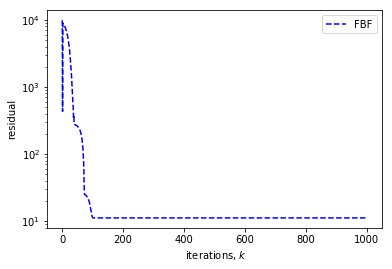

Answer is 11.169813757328976
Answer is [8.75963656e-172 8.28339749e-172 8.62528514e-172 8.87408587e-172
 8.79466408e-172 8.77007944e-172 9.41202011e-172 8.01171353e-172
 9.14958388e-172 9.49690249e-172 1.02095425e-164 1.02095425e-164
 1.02095425e-164 1.02095425e-164 1.02095425e-164 1.02095425e-164
 1.02095425e-164 1.02095425e-164 1.02095425e-164 1.02095425e-164
 3.43570562e-161 7.36276951e-160 9.53863484e-161 2.96797721e-160
 2.33879938e-160 6.90958193e-160 2.15551588e-160 1.16831439e-160
 2.44329425e-160 2.59704797e-161]
Answer is 5.474973768254071e-171


In [31]:
plt.plot(ans1[0], '--b', label = 'FBF')

plt.yscale('log')

plt.xlabel(u' iterations, $k$')
plt.ylabel(u'residual')

plt.legend()
#plt.savefig('figures/nash.pdf', bbox_inches='tight')
plt.show()
print("Answer is", ans1[0][-1])
print("Answer is", ans1[2])
print("Answer is", fx(ans1[2][0:dimX]))

In [26]:
ans1[1]

array([0.84333958, 0.        , 0.        , 0.        , 0.        ,
       0.        , 2.28715461, 0.        , 0.36884394, 2.06140825,
       0.01021835, 0.01021835, 0.01021835, 0.01021835, 0.01021835,
       0.01021835, 0.01021835, 0.01021835, 0.01021835, 0.01021835,
       1.21621228, 1.21390238, 0.64974323, 1.22774309, 2.69779052,
       2.22217267, 1.16268071, 1.57432292, 1.31228547, 0.16720319])

## Solving the QCQP

In [23]:
from scipy.optimize import minimize
cons = []
for i in range(len(hx)):
    temp = ({'type': 'ineq', 'fun': lambda x: hx[i](x) })
    cons.append(temp)
bnds = []
for i in range(dimX):
    temp = ((0, None))
    bnds.append(temp)
x = np.ones(dimX)
res = minimize(fx, x, method='SLSQP', bounds=bnds, constraints=cons)

In [24]:
print(fx(res['x']))
print(res['x'])
#print("Answer is:", res)

22.478066737252405
[4.34004870e+00 0.00000000e+00 1.38839345e-11 1.40058140e-11
 4.81151999e-13 9.14765367e-12 0.00000000e+00 2.12530896e-11
 3.72929798e-12 7.97988581e-03]
